In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

sys.path.insert(0, '/Users/diol5851/Documents/rental-housing-cost/')
from notebooks.data_cleaning_EDA.AHS_Parser import AHS_Parser
sys.path.remove('/Users/diol5851/Documents/rental-housing-cost/')

In [2]:
def get_dataset(year):
    raw_dat = pd.read_feather(f'../../data/AHS_{year}.feather')
    # Drop the year column, since that does not add information here.
    dat = raw_dat.drop(columns=['YEAR'])
    # Move ADEQUACY to the first column.
    adequacy = dat.pop('ADEQUACY')
    dat.insert(0, 'ADEQUACY', adequacy)
    # Drop apartments with four or more bathrooms.
    dat = dat[dat['BATHROOMS'] < 4]
    # Remap the ADEQUACY column to a binary column, where 1 is adequate.
    ad_default = defaultdict(lambda: 0)
    ad_default['Adequate'] = 1
    dat['ADEQUACY'] = dat['ADEQUACY'].map(ad_default)
    # Dropping columns that seem redundant for prediction.
    dat = dat.drop(columns = [
        'UTILAMT', 'HOAAMT', 'INSURAMT', 'FINCP', 'KITCHENS', 'DINING', 'LAUNDY', 'GARAGE', 'PORCH',
        'NUMNONREL', 'HHADLTKIDS', 'SUBDIV'
        ])
    # Parse the remaining categorical columns.
    parser = AHS_Parser()
    for col in dat.select_dtypes(include=['object']).columns:
        dat[col] = dat[col].astype('category')
        dat[col] = dat[col].cat.rename_categories(parser.parse_categorical(col, year))
        if 'Not reported' in dat[col].cat.categories:
            dat[col] = dat[col].cat.remove_categories(['Not reported'])
    # Drop columns with less than 20k non-null values.
    dat = dat.drop(columns = dat.columns[dat.count() < 20e3])
    # Drop all remaining null values.
    dat = dat.dropna()
    return dat

In [3]:
# Pull the 2023 AHS data.
dat = get_dataset(2023)
dat.drop(columns=['OMB13CBSA', 'ROACH', 'RODENT', 'SEWBREAK'], inplace=True)
dat.info()

## Generate training and testing sets that are balanced.
dat = dat.select_dtypes(exclude=['category']) # Need numeric data for SVM.
dat_adequate = dat[dat['ADEQUACY'] == 1]
dat_not_adequate = dat[dat['ADEQUACY'] == 0]
# Split the two dataframes into training and testing sets.
adequate_train, adequate_test = train_test_split(dat_adequate, test_size=0.2, random_state=42)
not_adequate_train, not_adequate_test = train_test_split(dat_not_adequate, test_size=0.2, random_state=42)
# Combine the training and test sets.
train = pd.concat([not_adequate_train] * 1)
train = pd.concat([adequate_train, train])
test = pd.concat([adequate_test, not_adequate_test])

<class 'pandas.core.frame.DataFrame'>
Index: 19997 entries, 0 to 55667
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADEQUACY    19997 non-null  int64   
 1   BLD         19997 non-null  category
 2   STORIES     19997 non-null  int64   
 3   YRBUILT     19997 non-null  int64   
 4   RENT        19997 non-null  int64   
 5   RENTSUB     19997 non-null  category
 6   TOTHCAMT    19997 non-null  int64   
 7   UNITFLOORS  19997 non-null  int64   
 8   BATHROOMS   19997 non-null  float64 
 9   BEDROOMS    19997 non-null  int64   
 10  TOTROOMS    19997 non-null  int64   
 11  ACPRIMARY   19997 non-null  category
 12  HEATTYPE    19997 non-null  category
 13  HOTWATER    19997 non-null  category
 14  SEWTYPE     19997 non-null  category
 15  WATSOURCE   19997 non-null  category
 16  COOKTYPE    19997 non-null  category
 17  DRYER       19997 non-null  category
 18  HINCP       19997 non-null  int64   
 19  NUMPEOPLE

## SVM Classifiers

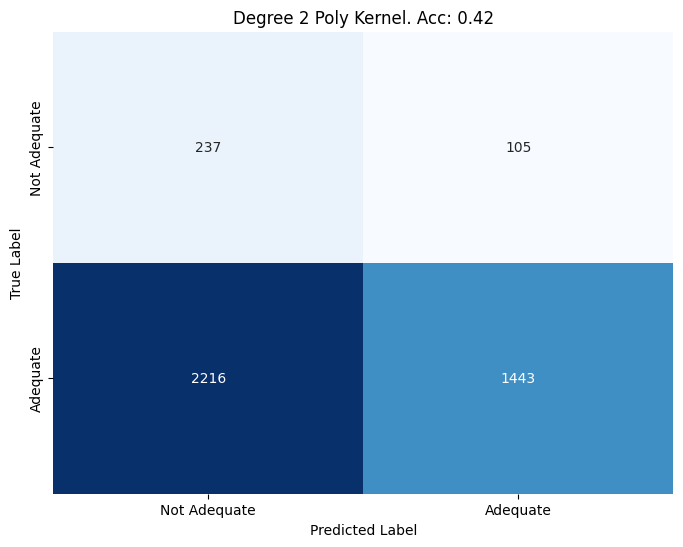

In [4]:
## SVC Classifier.
svm_d2 = SVC(
    kernel='poly', degree=2, coef0 = 1.5,
    C=2e2, 
    class_weight='balanced',
    random_state=42
)
svm_d2.fit(train.drop(columns=['ADEQUACY']), train['ADEQUACY'])
predictions = svm_d2.predict(test.drop(columns=['ADEQUACY']))
cm_d2 = confusion_matrix(test['ADEQUACY'], predictions)
# Plot confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_d2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Adequate', 'Adequate'],
            yticklabels=['Not Adequate', 'Adequate'])
plt.title(f'Degree 2 Poly Kernel. Acc: {cm_d2.diagonal().sum() / cm_d2.sum():.2f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

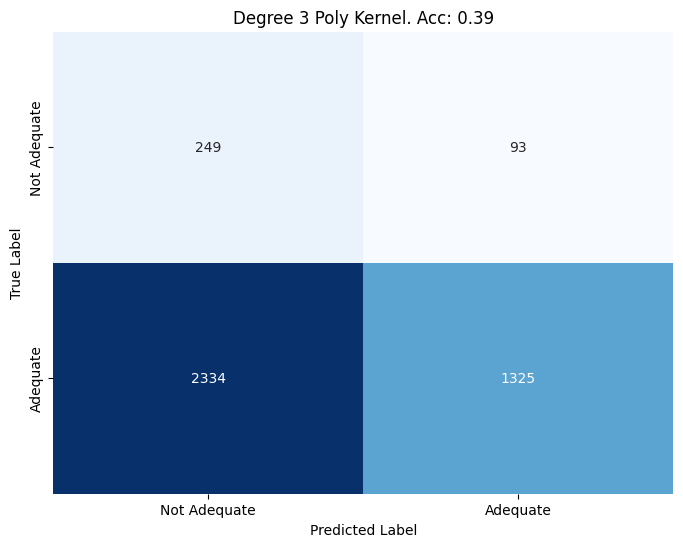

In [5]:
## SVC Classifier.
svm_d3 = SVC(
    kernel='poly', degree=3, coef0 = 1.0,
    C=2e2, 
    class_weight='balanced',
    random_state=42
)
svm_d3.fit(train.drop(columns=['ADEQUACY']), train['ADEQUACY'])
predictions = svm_d3.predict(test.drop(columns=['ADEQUACY']))
cm_d3 = confusion_matrix(test['ADEQUACY'], predictions)
# Plot confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_d3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Adequate', 'Adequate'],
            yticklabels=['Not Adequate', 'Adequate'])
plt.title(f'Degree 3 Poly Kernel. Acc: {cm_d3.diagonal().sum() / cm_d3.sum():.2f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

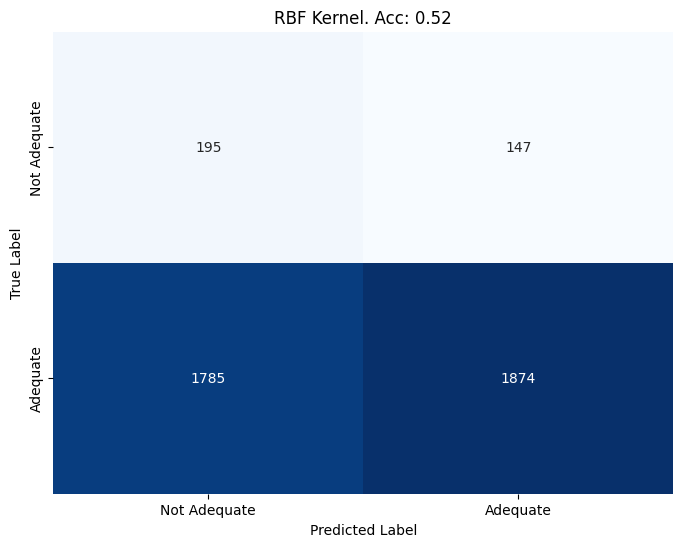

In [6]:
## SVC Classifier.
svm_rbf = SVC(
    kernel='rbf',
    C=5e3, 
    class_weight='balanced',
    random_state=42
)
svm_rbf.fit(train.drop(columns=['ADEQUACY']), train['ADEQUACY'])
predictions = svm_rbf.predict(test.drop(columns=['ADEQUACY']))
cm_rbf = confusion_matrix(test['ADEQUACY'], predictions)
# Plot confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Adequate', 'Adequate'],
            yticklabels=['Not Adequate', 'Adequate'])
plt.title(f'RBF Kernel. Acc: {cm_rbf.diagonal().sum() / cm_rbf.sum():.2f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()